# Logistic Regression using sklearn

<p>The following notebook provides an example code of analyzing <b>Employee attrition</b> using logistic regression. The dependent variable is <b>Attrition (leaving the company) ("Yes", "No")</b>. 
    
<br>The general sequence of steps for the analysis the following:
1. [Descriptive analysis](#pandas)
2. [Logistic regression using sklearn](#stats)
3. [Cross Validation, Hyperparameter tuning using GridSearch](#stats1)
4. [Model evaluation](#stats2)

 <h2>1.Descriptive analysis</h2> <a name="pandas"></a>

The initial data consists of 1470 observations of 35 variables.There are no duplicates and missing values, however data contains 3 variables with single value for all observations ('EmployeeCount', 'Over18', 'StandardHours'), which we dropped.
The target is categorical ("Yes", "No"), and for sake of simplicity we recoded them as 1 for "Yes" and 0 for "No". 
Employee attrition is not evenly balanced between 0s and 1s. As the countplot and value counts show, only about 16% of employees are leaving and ~84% are staying.So we can use this info as a naive assumption for newcomers to decide whether they'll leave or stay. In other words, if the resulting score is more than the noted value, then our model will be not bad, otherwise-a bad one. 

In order to optimize the number of variables, we observed heatmap,boxplots for all numeric variables by Attrition and Attrition rate (in %) by each categorical variable. This information, combined, will be used later for variable transformation/elimination.

We have high correlations of Monthly Income and JobLevel (0.95), multicollinearity between all variables referring to Years (i.e. Years since last promotion, Years with current manager etc.), Monthly income and Total working Years etc.


In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
#data manipulation and visualization libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#libraries for modelling and evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.metrics import accuracy_score,recall_score,confusion_matrix,classification_report,roc_auc_score,roc_curve

In [2]:
#importing the data and making a dataframe
data=pd.read_csv("Employee_attrition.csv")

In [3]:
#data overview
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
Age                         1470 non-null int64
Attrition                   1470 non-null object
BusinessTravel              1470 non-null object
DailyRate                   1470 non-null int64
Department                  1470 non-null object
DistanceFromHome            1470 non-null int64
Education                   1470 non-null int64
EducationField              1470 non-null object
EmployeeCount               1470 non-null int64
EmployeeNumber              1470 non-null int64
EnvironmentSatisfaction     1470 non-null int64
Gender                      1470 non-null object
HourlyRate                  1470 non-null int64
JobInvolvement              1470 non-null int64
JobLevel                    1470 non-null int64
JobRole                     1470 non-null object
JobSatisfaction             1470 non-null int64
MaritalStatus               1470 non-null object
MonthlyIncome         

In [4]:
#have a look at first rows of the dataframe
data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [5]:
data.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,...,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,1.0,1024.865306,2.721769,65.891156,2.729932,2.063946,...,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,0.0,602.024335,1.093082,20.329428,0.711561,1.106940,...,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,...,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,1.0,491.250000,2.000000,48.000000,2.000000,1.000000,...,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,1.0,1020.500000,3.000000,66.000000,3.000000,2.000000,...,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,1.0,1555.750000,4.000000,83.750000,3.000000,3.000000,...,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,...,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


In [6]:
#checking number of duplicates, missing values and columns with a single value
print("Duplicates:", data.duplicated().sum())
print("Missing values:", data.isna().sum().sum())
print("Single valued columns:", data.columns[data.nunique()==1])

Duplicates: 0
Missing values: 0
Single valued columns: Index(['EmployeeCount', 'Over18', 'StandardHours'], dtype='object')


In [7]:
#Employee number is a unique id number, so we will keep it setting to index
data.set_index(keys='EmployeeNumber', inplace=True)

In [8]:
#dropping columns with single value
data.drop(['EmployeeCount', 'Over18', 'StandardHours'],axis=1, inplace=True)

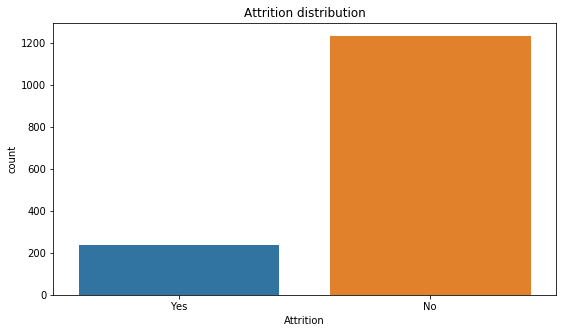

In [9]:
#let's visualise the distribution of churn
plt.figure(figsize=(9,5))
sns.countplot(data.Attrition)
plt.title("Attrition distribution")
plt.show()

In [10]:
#transforming the target to binary
data.Attrition=data.Attrition.map({'No':0, 'Yes':1})

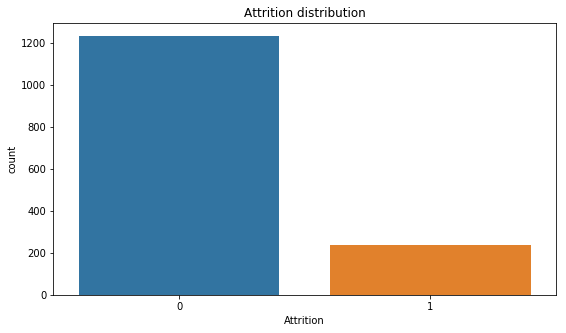

In [11]:
#let's visualise the distribution of churn
plt.figure(figsize=(9,5))
sns.countplot(data.Attrition)
plt.title("Attrition distribution")
plt.show()

In [12]:
#lets count the benchmark for employee churn
data.Attrition.value_counts(normalize=True).mul(100).rename("attrition percentage")

0    83.877551
1    16.122449
Name: attrition percentage, dtype: float64

In [13]:
data.tail()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
EmployeeNumber,,,,,,,,,,,,,,,,,,,,,
2061,36,0,Travel_Frequently,884,Research & Development,23,2,Medical,3,Male,...,3,3,1,17,3,3,5,2,0,3
2062,39,0,Travel_Rarely,613,Research & Development,6,1,Medical,4,Male,...,3,1,1,9,5,3,7,7,1,7
2064,27,0,Travel_Rarely,155,Research & Development,4,3,Life Sciences,2,Male,...,4,2,1,6,0,3,6,2,0,3
2065,49,0,Travel_Frequently,1023,Sales,2,3,Medical,4,Male,...,3,4,0,17,3,2,9,6,0,8
2068,34,0,Travel_Rarely,628,Research & Development,8,3,Medical,2,Male,...,3,1,0,6,3,4,4,3,1,2


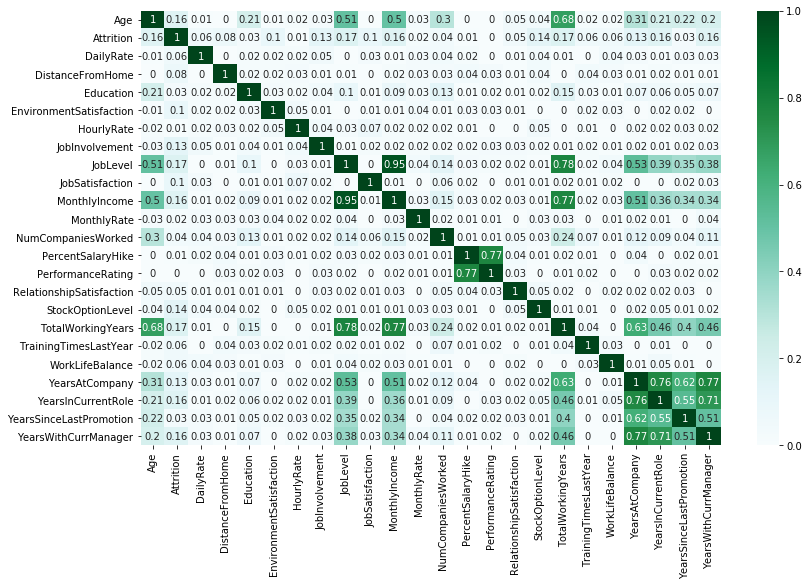

In [14]:
#Let's visualize correlations
plt.figure(figsize=(13,8))
sns.heatmap(data.corr().abs().round(2),annot=True, cmap = "BuGn")

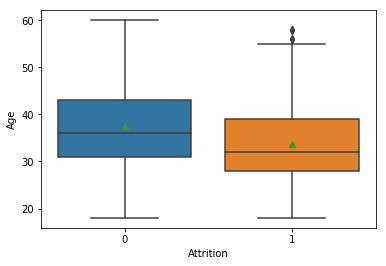

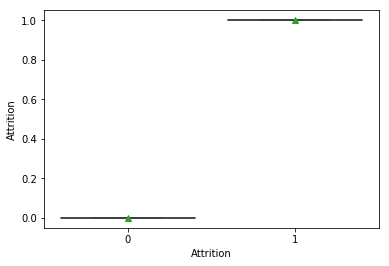

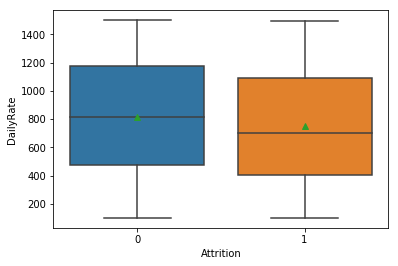

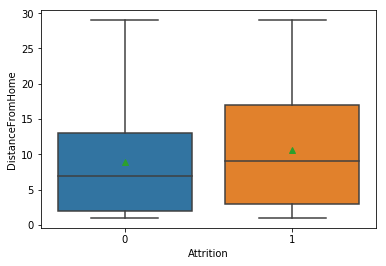

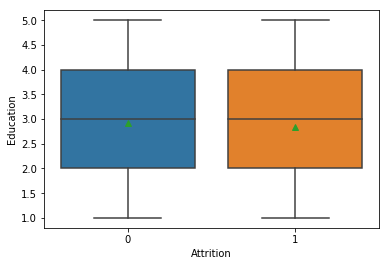

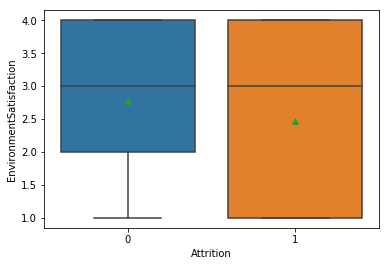

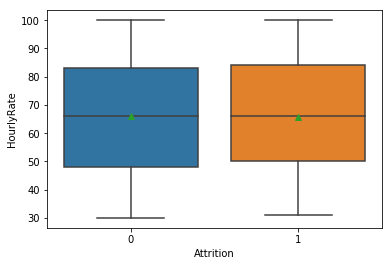

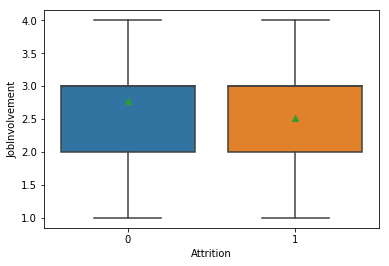

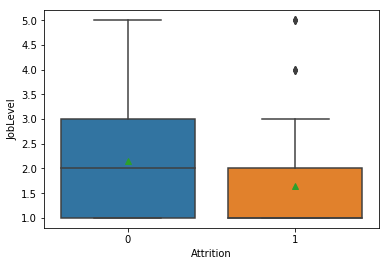

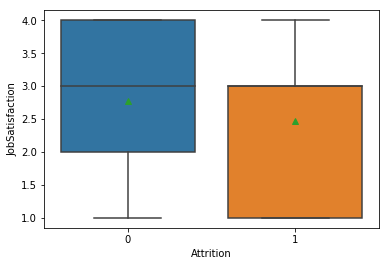

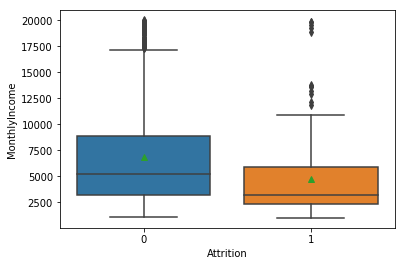

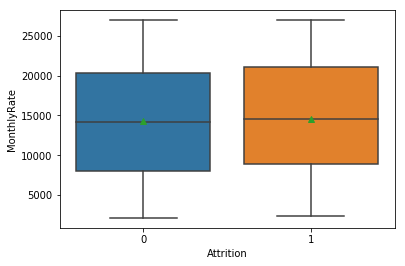

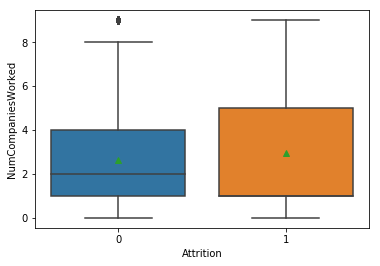

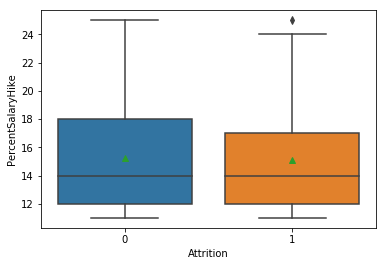

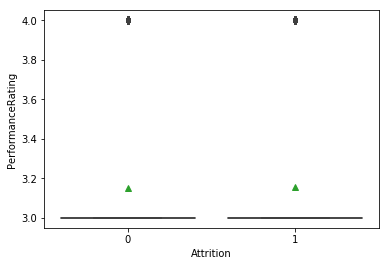

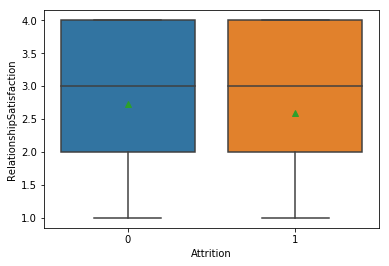

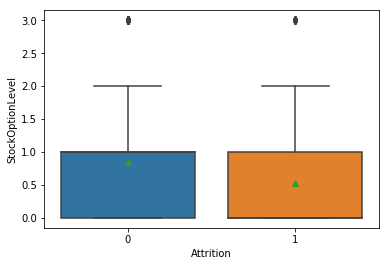

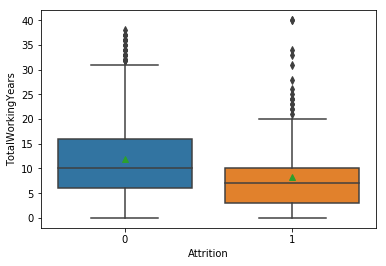

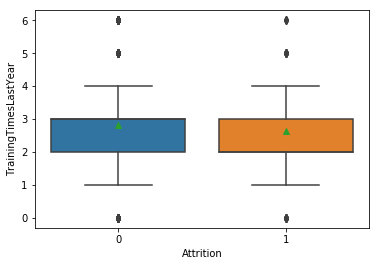

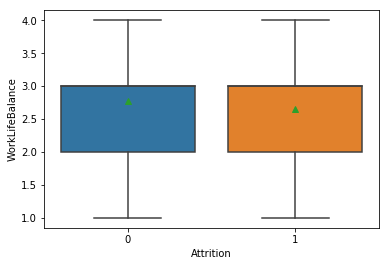

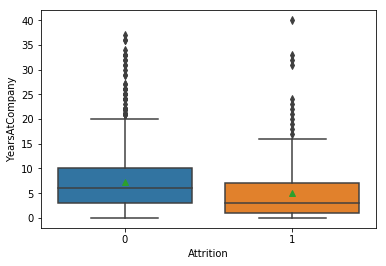

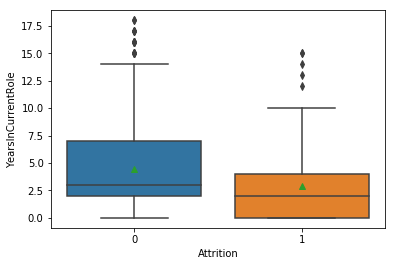

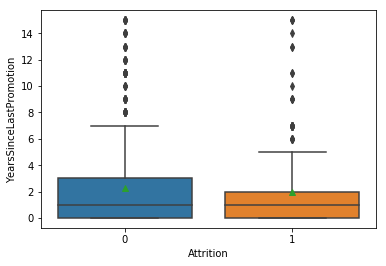

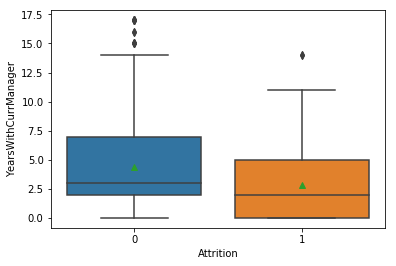

In [15]:
#Let's also see whether mean Final grade differs by any of the categorical variables.
#to see that, let's visualize Final grade by each categorical variable represented in boxplot.
for i in data.dtypes[data.dtypes!="O"].index.tolist():
    sns.boxplot(data=data,y=i,x="Attrition", showmeans=True)
    plt.show()

In [16]:
#creating attrition rate by each categorical variable
#data using groupby. parameter: "normalize"in value_counts() returns relative frequencies, "mul" multiplies by noted number
#(in this case-100,to get %)
rates_list=[]
for i in data.dtypes[data.dtypes=="O"].index.tolist():
    rates=data.groupby(i)["Attrition"].value_counts(normalize=True).rename("percentage").mul(100).reset_index()
    rates_list.append(rates)

In [17]:
#one of the resulting dfs
rates_list[0]

,BusinessTravel,Attrition,percentage
0,Non-Travel,0,92.000000
1,Non-Travel,1,8.000000
2,Travel_Frequently,0,75.090253
3,Travel_Frequently,1,24.909747
4,Travel_Rarely,0,85.043145
5,Travel_Rarely,1,14.956855


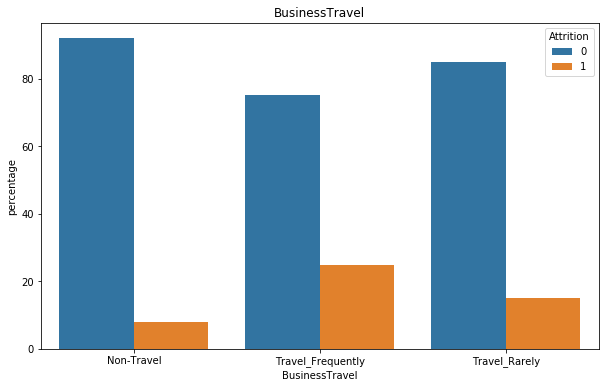

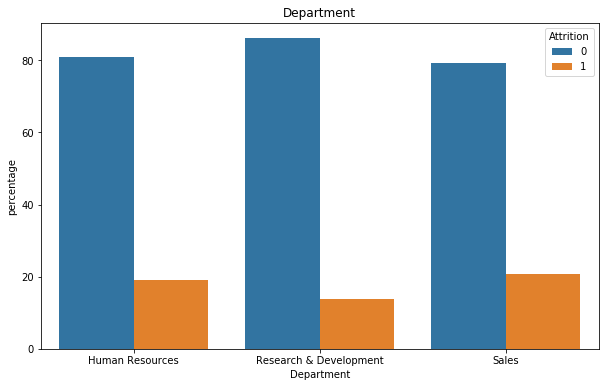

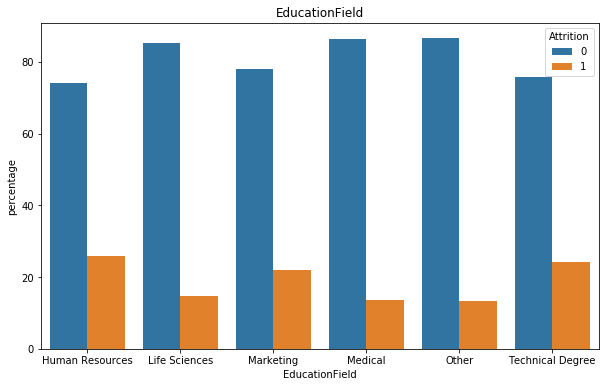

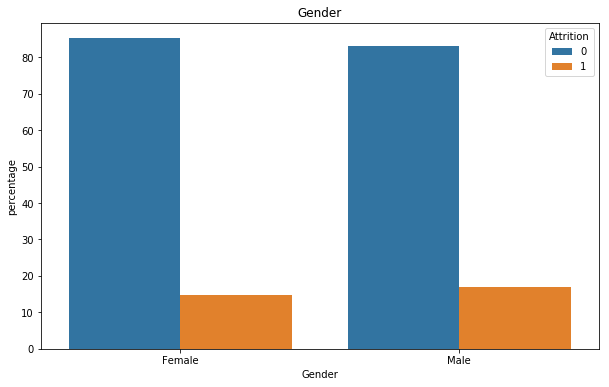

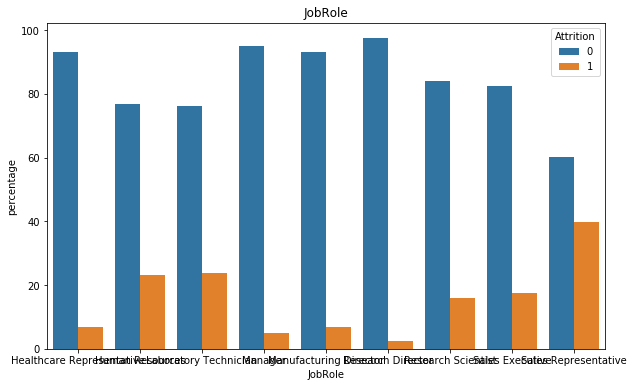

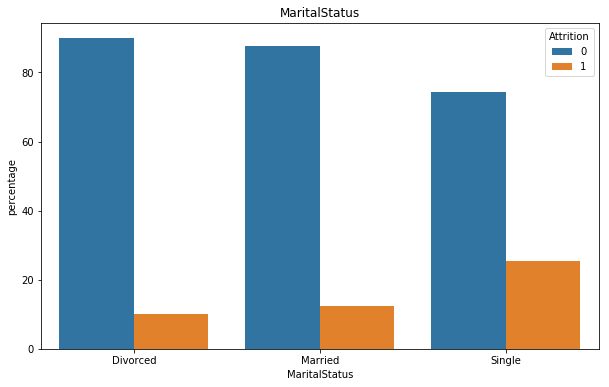

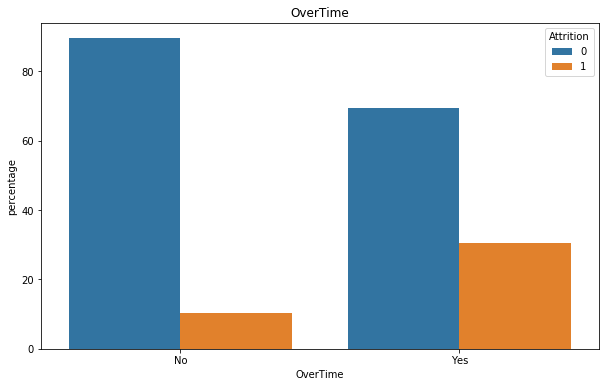

In [18]:
#creating barplots showing percentage distribution of attrition by each category
for i in rates_list:
    plt.figure(figsize=(10,6))
    sns.barplot(x=i.iloc[:,0], y=i.iloc[:,2], hue=i.iloc[:,1])
    plt.title(i.columns[0])
    plt.show()

<h1> 2. Logistic regression using sklearn</h1> <a name="stats"> </a>

We decided first to run model on not transformed data, see its performance and make data transformations accordingly. We got 0.68 and 0.63 ROC AUC score for train and test sets, respectively, which shows that model has place for improvement.
Therefore, we dropped several numeric and categorical variables based on already observed visual evidence.

In particular, we decided to keep only Total Working Years variable among all others connected somehow to number of years,
keep Monthly rate (drop hourly and daily rates) and relevel the number of categories of some categorical variables, to have less columns. Also, decided to drop JobRole, as have department variable which is more general in terms of describing job and has less categories. Will not also keep Gender, as the percentage distribution of both leaving and staying people in the company is more or less the same (see plots in descriptive part).

Next steps will be as following:
- find best parameters for the model using GridSearch on training set
- fit the training set using best parameters
- calculate roc_auc scores for training and testing sets
- calculate cross-validation score for the whole dataset.
- calculate other evaluation metrics (classification report, recall etc.)

In [19]:
#dropping columns
data.drop(['YearsAtCompany','Education','HourlyRate','DailyRate','YearsInCurrentRole','YearsSinceLastPromotion',
           'YearsWithCurrManager','JobLevel','MonthlyRate','PerformanceRating','JobRole'], axis=1,inplace=True)

In [20]:
#making dummes,train test split
data=pd.get_dummies(data, drop_first=True)

In [21]:
#separating X and Y
Y=data["Attrition"]
X=data.drop("Attrition",axis=1)

In [22]:
#let's split X and Y data into test and train datasets, test data is 25% of overall data
#splitting the data into train and test sets
X0, X1, Y0, Y1 = train_test_split(X, Y, test_size=0.25, random_state=42)

In [23]:
logit=LogisticRegression(random_state=42)

In [24]:
logit.fit(X0,Y0)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [25]:
#calculating roc auc score
print("ROC_AUC Train:",roc_auc_score(Y0,logit.predict_proba(X0)[:,1]*100).round(2))
print("ROC_AUC Test:",roc_auc_score(Y1,logit.predict_proba(X1)[:,1]*100).round(2))

ROC_AUC Train: 0.85
ROC_AUC Test: 0.79


<h1> 3. Cross Validation, Hyperparameter tuning using GridSearch</h1> <a name="#stats1"> </a>

<b><i>As we saw during the session, when changing the hyperparameters of the LogisticRegression (i.e "C", "class_weight"), the resulting roc_auc scores also change.
Thus, lets use GridSearch not to find hyperparameter values manually.
    
First we have to define ranges for the parameters (parameter grid).    
Next, by running it, gridsearch implements exhaustive search over specified parameter values for an estimator (in our case-Logistic Regression).
The parameters of the estimator used to apply these methods are optimized by cross-validated grid-search over a parameter grid.</i></b>

In [26]:
param_logit={'class_weight':[None,'balanced'],
            'C':np.linspace(1,10,80),}

In [27]:
gridsearch = GridSearchCV(estimator=logit,
                        param_grid=param_logit,
                        cv=5,scoring='roc_auc',verbose=1)

In [28]:
#note that we have 2x80=160 different combinations of C and class weight, and if we 
#choose number of folds, the total number of fits will be calculated by also mulpitlying that
# number-2*80*5=800. So Gridsearch will implement 800 fits and find best parameters using
#respective roc_auc scores. 
gridsearch.fit(X0, Y0)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:   24.1s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'class_weight': [None, 'balanced'], 'C': array([ 1.     ,  1.11392, ...,  9.88608, 10.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [29]:
#let's see the optimal parameters
gridsearch.best_params_

{'C': 6.012658227848101, 'class_weight': None}

<h1> 4. Model evaluation</h1> <a name="stats2"> </a>

In [30]:
#let's construct logit with the best parameters 
logit2=LogisticRegression(class_weight='balanced',C=8.163267142857142,random_state=42).fit(X0,Y0)

In [31]:
#Let's see what is the roc score when using best parameters
#making predictions
Y0_logit2=logit2.predict(X0)
Y1_logit2=logit2.predict(X1)

In [32]:
#calculating roc auc score
print("ROC_AUC Train:",roc_auc_score(Y0,logit2.predict_proba(X0)[:,1]*100).round(2))
print("ROC_AUC Test:",roc_auc_score(Y1,logit2.predict_proba(X1)[:,1]*100).round(2))

ROC_AUC Train: 0.85
ROC_AUC Test: 0.79


In [33]:
#Note that we can also calculate accuracy, recall and ROC_AUC score using respective metrics from sklearn library
#summarizing the results into a dataframe
results_summary=pd.DataFrame({"Accuracy":[accuracy_score(Y0,Y0_logit2),accuracy_score(Y1,Y1_logit2)],
                              "ROC_AUC":[roc_auc_score(Y0,logit2.predict_proba(X0)[:,1]*100).round(2),roc_auc_score(Y1,logit2.predict_proba(X1)[:,1]*100).round(2)],
                              "Recall":[recall_score(Y0, Y0_logit2),recall_score(Y1, Y1_logit2)]
                              },
                             index=["Training set","Testing set"])
results_summary


,Accuracy,ROC_AUC,Recall
Training set,0.772232,0.85,0.788360
Testing set,0.750000,0.79,0.645833


In [34]:
#calculating using classification report
print("Logistic Regression Train:")
print(classification_report(Y0,Y0_logit2))

print("Logistic Regression Test:")
print(classification_report(Y1,Y1_logit2))

Logistic Regression Train:
              precision    recall  f1-score   support

           0       0.95      0.77      0.85       913
           1       0.41      0.79      0.54       189

   micro avg       0.77      0.77      0.77      1102
   macro avg       0.68      0.78      0.70      1102
weighted avg       0.85      0.77      0.80      1102

Logistic Regression Test:
              precision    recall  f1-score   support

           0       0.94      0.77      0.84       320
           1       0.29      0.65      0.40        48

   micro avg       0.75      0.75      0.75       368
   macro avg       0.61      0.71      0.62       368
weighted avg       0.85      0.75      0.78       368



In [35]:
#let's find cross validation score for the logit2, you can see 5 different results for each fold
cv_scores=cross_val_score(logit2,X,Y,cv=5,scoring="roc_auc")
cv_scores

array([0.83780364, 0.83350202, 0.79507279, 0.77633627, 0.83013319])

In [36]:
#mean cross vildation score
np.mean(cv_scores)

0.8145695850640132

*Note!: We can see that the result obtained via cross validation is more than through single split*